In [374]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [170]:
## Standard :

# Name imports :
import os
import gc
import copy
import sklearn
import itertools
import time
import typing
import random

# Aliased imports :
import multiprocessing as mp
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sb
import matplotlib.pyplot as plt

# Full imports :
from plotnine import *

In [213]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)
sb.set_style("dark")

In [172]:
def split(arr: list, count: int) -> typing.List[list]:
    return [arr[i::count] for i in range(count)]

def overlapping_histograms(df: pd.core.frame.DataFrame, 
                           columns: typing.List[str], 
                           names=None, 
                           colors: typing.List[str]=None,
                           labels: typing.Tuple[str]=None
                          ) -> bool:
    """ Create a figure with overlapping histograms and KDEs from 
    a dataframe's specified columns.
    
    df : A pandas.core.frame.DataFrame
    columns : Names of the columns that will be used to construct the histograms.
    names :  Used to label each histogram and KDE, defaults to 'columns'.
    colors :  A list of colors for the histograms. See sb.xkcd_rgb for available colors.
    labels : A tuple containing ('Plot Title', 'xlabel', 'ylabel' )
    
    Returns: 
        True uppon success
        False uppon an error i.e. 
                One of the specified columns isn't found
                on df.columns
    """
    for col in columns:
        if not (col in df.columns):
            return False
    
    if not names:
        names = columns
    
    if not colors:
        colors = [random.choice(list(sb.xkcd_rgb.values())) for i in range(len(columns))]
    
    for column, name, color in zip(columns, names, colors):
        sb.distplot(
            raw[column].dropna(), 
            kde_kws={"color":color,"lw":2,"label":name,"alpha":0.6}, 
            hist_kws={"color":color,"alpha":0.25}
        )
    
    if labels:
        plt.title(labels[0])
        plt.xlabel(labels[1])
        plt.ylabel(labels[2])
    
    return True
    

def select_date_range(df: pd.core.frame.DataFrame, 
                     start_date: str, 
                     end_date: str) -> pd.core.frame.DataFrame:
    """
    """
    mask = (df.index >= start_date) & (df.index <= end_date)
    
    

def time_indexed_df(df1: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """ Cast into a time-indexed dataframe.
    df1 paramater should contain a column called 'dateTime',
    which contains entries of type pandas._libs.tslibs.timestamps.Timestamp
    """
    _tmp = copy.deepcopy(df1)
    _tmp.index = df1.dateTime
    _tmp.drop('dateTime', axis=1, inplace=True)
    _tmp = _tmp.sort_index()
    gc.collect()
    return _tmp

def merge_date_time(df1: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """ Take a dataframe containing columns:
        'Date'
        'Time'
        
        And return one containing a single column:
         'dateTime' = 'Date' + 'Time'
        
        For each entry as seen below:
         '2019-03-21 17:34:05' <- '2019-03-21' + '17:34:05'
    """
    _tmp = copy.deepcopy(df1)
    _tmp['dateTime'] = _tmp['Date'] + ' ' + _tmp['Time']
    _tmp.drop(['Date', 'Time'], axis=1, inplace=True)
    gc.collect()
    return _tmp
    

In [273]:
raw = pd.read_csv('data/carelink2.csv')

/home/gml/anaconda3/envs/DiabManager/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3,8,9,10,13,14,16,17,18,32,34,37,39,41,42,44,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [274]:
raw.columns, len(raw.index)

(Index(['Index', 'Date', 'Time', 'New Device Time', 'BG Reading (mg/dL)',
        'Linked BG Meter ID', 'Basal Rate (U/h)', 'Temp Basal Amount',
        'Temp Basal Type', 'Temp Basal Duration (h:mm:ss)', 'Bolus Type',
        'Bolus Volume Selected (U)', 'Bolus Volume Delivered (U)',
        'Bolus Duration (h:mm:ss)', 'Prime Type', 'Prime Volume Delivered (U)',
        'Alarm', 'Suspend', 'Rewind', 'BWZ Estimate (U)',
        'BWZ Target High BG (mg/dL)', 'BWZ Target Low BG (mg/dL)',
        'BWZ Carb Ratio (g/U)', 'BWZ Insulin Sensitivity (mg/dL/U)',
        'BWZ Carb Input (grams)', 'BWZ BG Input (mg/dL)',
        'BWZ Correction Estimate (U)', 'BWZ Food Estimate (U)',
        'BWZ Active Insulin (U)', 'Sensor Calibration BG (mg/dL)',
        'Sensor Glucose (mg/dL)', 'ISIG Value', 'Event Marker', 'Bolus Number',
        'Bolus Cancellation Reason', 'BWZ Unabsorbed Insulin Total (U)',
        'Final Bolus Estimate', 'Scroll Step Size', 'Insulin Action Curve Time',
        'Sensor C

In [275]:
#raw['Bolus Source'].value_counts()
#raw['Bolus Number'].value_counts()
#len(raw['dateTime'])
#raw['BWZ Unabsorbed Insulin Total (U)'].value_counts()
#raw['Bolus Cancellation Reason'].value_counts()
raw['Bolus Number'] = raw['Bolus Number'].apply(lambda x: int(x) if type(x) is str else x)

In [276]:
# Check if the list contains other thing than integers.
list(
    filter(
        lambda x: False if type(x) is int else True, raw['Final Bolus Estimate'].value_counts()
    )
)

[]

In [277]:
type(5) is int

True

In [278]:
raw = merge_date_time(raw)

In [279]:
# Remove ['MiniMed 640G MMT-1512/1712 Sensor', 'Date Time'] from the column, 
# as they impede coercing the values into timestamps.
for row in filter(lambda x: False if ':' in x else True, raw['dateTime'] ):
    raw = raw[raw.dateTime != row]

In [280]:
pool = mp.Pool() # processes parameter can be set manually, 
                 # but this is suposed to spawn the same number as the system has cores.
start = time.clock()
raw.dateTime = pool.map(pd.to_datetime, raw.dateTime)
elapsed = time.clock()
print(f'{elapsed - start}')

0.6996690000000001


In [281]:
undesired_columns = [
    'Index',
    'Temp Basal Type', 
    'Temp Basal Duration (h:mm:ss)',
    'BWZ Target High BG (mg/dL)', 
    'BWZ Target Low BG (mg/dL)',
    'Bolus Type',
    'Insulin Action Curve Time',
    'New Device Time',
    'Bolus Duration (h:mm:ss)',
    'Prime Type', 
    'Prime Volume Delivered (U)',
    'Alarm',
    'ISIG Value',
    'Event Marker',
    'Bolus Number',
    'Suspend', 
    'Rewind',
    'Linked BG Meter ID',
    'Bolus Cancellation Reason',
    'Scroll Step Size',
    'Sensor Calibration Rejected Reason',
    'Network Device Associated Reason',
    'Network Device Disassociated Reason',
    'Network Device Disconnected Reason',
    'Sensor Exception',
    'Preset Temp Basal Name',
    'Preset Bolus', 
    'Bolus Source'
]

In [282]:
raw = raw.drop(undesired_columns, axis=1)

In [283]:
raw.columns

Index(['BG Reading (mg/dL)', 'Basal Rate (U/h)', 'Temp Basal Amount',
       'Bolus Volume Selected (U)', 'Bolus Volume Delivered (U)',
       'BWZ Estimate (U)', 'BWZ Carb Ratio (g/U)',
       'BWZ Insulin Sensitivity (mg/dL/U)', 'BWZ Carb Input (grams)',
       'BWZ BG Input (mg/dL)', 'BWZ Correction Estimate (U)',
       'BWZ Food Estimate (U)', 'BWZ Active Insulin (U)',
       'Sensor Calibration BG (mg/dL)', 'Sensor Glucose (mg/dL)',
       'BWZ Unabsorbed Insulin Total (U)', 'Final Bolus Estimate', 'dateTime'],
      dtype='object')

In [284]:
unsure_columns = [
    'BG Reading (mg/dL)',
    'Sensor Calibration BG (mg/dL)'
]

In [285]:
proc1 = raw.drop(unsure_columns, axis=1)

In [286]:
proc1 = time_indexed_df(proc1)

True

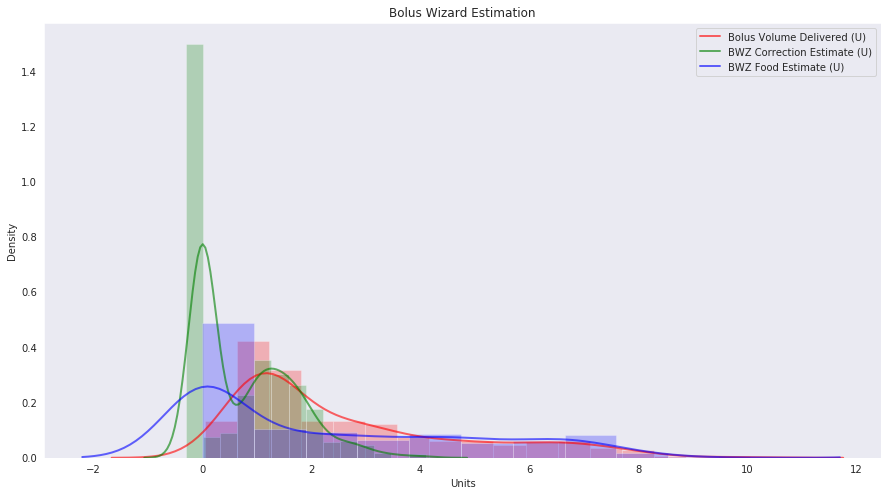

In [287]:
overlapping_histograms(proc1, 
                       ['Bolus Volume Delivered (U)', 'BWZ Correction Estimate (U)', 'BWZ Food Estimate (U)'],
                       colors=['red', 'green', 'blue'], 
                       labels=('Bolus Wizard Estimation', 'Units', 'Density')
                      )

In [288]:
len(proc1['Basal Rate (U/h)']), proc1['Basal Rate (U/h)'].count()

(96130, 5794)

In [185]:
#with sb.axes_style('white'):
 #   sb.jointplot('Bolus Volume Delivered (U)', 'BWZ Correction Estimate (U)', raw[['Bolus Volume Delivered (U)', 'BWZ Correction Estimate (U)']].dropna(), kind='hex')

In [290]:
len(proc1['2019']['Basal Rate (U/h)']), proc1['2019']['Basal Rate (U/h)'].interpolate(method='pad').count()

(43711, 42457)

In [385]:
#proc1.loc['2019/02/10 01':'2019/02/10 02']['Basal Rate (U/h)']

In [413]:
def hybrid_interpolator(data: pd.core.series.Series, 
                        methods: typing.List[str] = ['linear', 'spline'], 
                        weights: typing.List[float] = [0.85, 0.15],
                        direction: str = 'both',
                        order: int = 2
                       ) -> pd.core.series.Series:
    """
    Return a pandas.core.series.Series instance resulting of the weighted average
    of two interpolation methods.
    
    Model:
        φ = β1*method1 + β2*method2
        
    Default:
        β1, β2 = 0.6, 0.4
        method1, method2 = linear, spline
    
    limit_direction : {‘forward’, ‘backward’, ‘both’}, default ‘forward’
    If limit is specified, consecutive NaNs will be filled in this direction.
    
    This function should have support for keyword arguments, but is yet to be implemented.
    """
    predictions: typing.List[float] = [] 
    
    if sum(weight for weight in weights) > 1:
        raise Exception('Sum of weights must be equal to one!')
    
    for met in methods:
        if (met == 'spline') or (met == 'polynomial'):
            predictions.append(data.interpolate(method=met, order=order, limit_direction=direction))
        else:
            predictions.append(data.interpolate(method=met, limit_direction=direction))

    #linear = predictions[0]
    #spline = predictions[1]
    
    #print(linear[ np.isnan(data) ])
    
    # working version:
    interpolated = weights[0]*predictions[0] + weights[1]*predictions[1]
    
    #df = copy.deepcopy(interpolated)
    #print(df.isnull().astype(int).groupby(df.notnull().astype(int).cumsum()).sum())
    
    return interpolated
        
    

In [421]:
def dev_from_mean(data: pd.core.series.Series) -> None:
    """
    https://stackoverflow.com/questions/38711541/how-to-compute-the-probability-of-a-value-given-a-list-of-samples-from-a-distrib
    calculate probabilitiés avec ça.
    """
    _mean: float = data.mean()
    _devs: pd.core.series.Series = np.abs(data - _mean)
    _avg_dev_mean: float = _devs.mean()
        
    return _mean, _devs, _avg_dev_mean
    
    

In [426]:
mean_dev, dev, _avg_dev_mean = dev_from_mean(proc2['Sensor Glucose (mg/dL)'])
mean_dev - 2*_avg_dev_mean

70.26009072475964

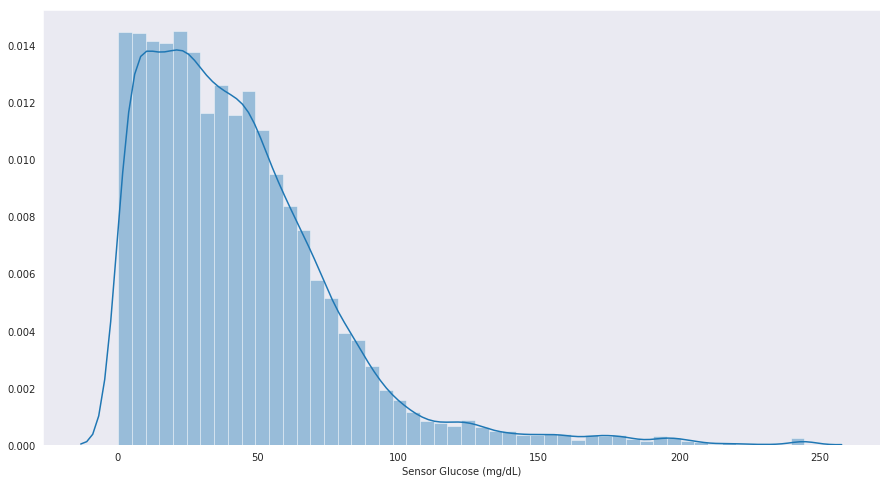

In [427]:
sb.distplot(dev.dropna())

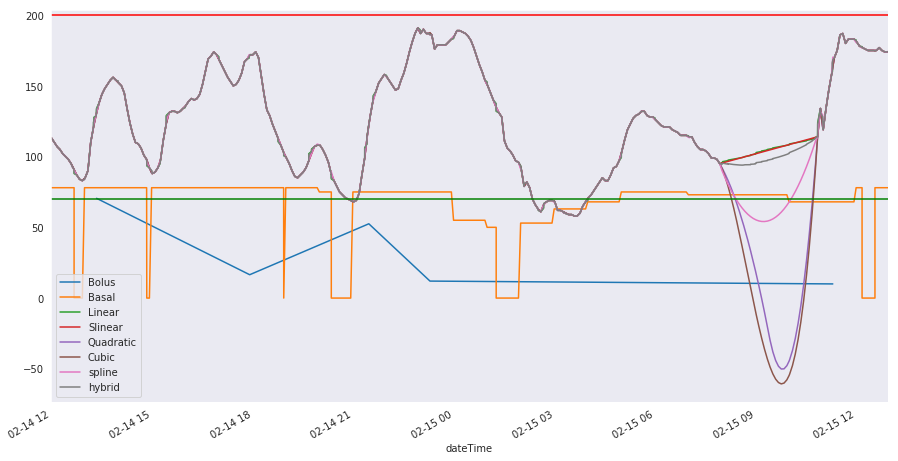

In [414]:
(proc1.loc['2019/02/14 12':'2019/02/15 12']['Bolus Volume Delivered (U)'].dropna()*10).plot()
(proc1.loc['2019/02/14 12':'2019/02/15 12']['Basal Rate (U/h)'].interpolate(method='pad')*100).plot()
proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)'].interpolate(method='linear').plot()
proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)'].interpolate(method='slinear').plot()
proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)'].interpolate(method='quadratic').plot()
proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)'].interpolate(method='cubic').plot()
proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)'].interpolate(method='spline', order=2).plot()
hybrid_interpolator(proc1.loc['2019/02/14 12':'2019/02/15 12']['Sensor Glucose (mg/dL)']).plot()
plt.axhline(200, color='red')
plt.axhline(70, color='green')
plt.legend(['Bolus', 'Basal', 'Linear', 'Slinear', 'Quadratic', 'Cubic', 'spline', 'hybrid'])

In [415]:
test_day = copy.deepcopy(proc1.loc['2019/02/14 12':'2019/02/14 22']['Sensor Glucose (mg/dL)'])
gap1 = copy.deepcopy(test_day)

In [416]:
proc2 = proc1.loc['2019/02/05':'2019/04/23']

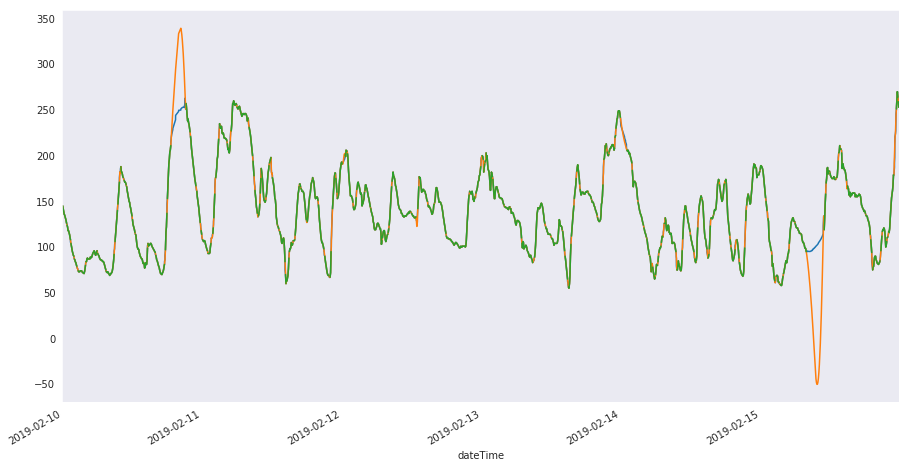

In [420]:
hybrid_interpolator(proc2.loc['2019/02/10':'2019/02/15']['Sensor Glucose (mg/dL)']).plot()
proc2.loc['2019/02/10':'2019/02/15']['Sensor Glucose (mg/dL)'].interpolate(method='polynomial', order=2).plot()
proc2.loc['2019/02/10':'2019/02/15']['Sensor Glucose (mg/dL)'].plot()


In [394]:
list(filter(lambda x: not x, sorted(proc2.index) == proc2.index))

[]

In [379]:
df = copy.deepcopy(test_day)
x = df.isnull().astype(int).groupby(df.notnull().astype(int).cumsum()).sum()
#x

In [361]:
gap1.loc['2019/02/14 20:00':'2019/02/14 20:30'] = np.nan
gap1.loc['2019/02/14 13:45':'2019/02/14 14:25'] = np.nan
#gap1.loc['2019/02/14 17:45':'2019/02/14 18:15'] = np.nan

dateTime
2019-02-14 12:00:00    113.000000
2019-02-14 12:00:00    113.000000
2019-02-14 12:38:00     93.000000
2019-02-14 12:41:22     90.000000
2019-02-14 12:41:22     89.000000
2019-02-14 12:41:22     88.000000
2019-02-14 13:00:00     84.000000
2019-02-14 13:16:13    122.125000
2019-02-14 13:16:13    123.250000
2019-02-14 13:16:13    124.375000
2019-02-14 13:16:49    125.500000
2019-02-14 13:16:49    126.625000
2019-02-14 13:16:50    127.750000
2019-02-14 13:20:54    128.875000
2019-02-14 13:21:34    134.000000
2019-02-14 13:46:06    147.818182
2019-02-14 13:51:06    144.636364
2019-02-14 13:56:06    141.454545
2019-02-14 14:00:00    138.272727
2019-02-14 14:00:00    135.090909
2019-02-14 14:01:06    131.909091
2019-02-14 14:06:06    128.727273
2019-02-14 14:11:06    125.545455
2019-02-14 14:16:06    122.363636
2019-02-14 14:21:06    119.181818
2019-02-14 14:51:22     96.500000
2019-02-14 14:51:22     95.000000
2019-02-14 14:51:22     93.500000
2019-02-14 15:00:00     90.000000
2019-

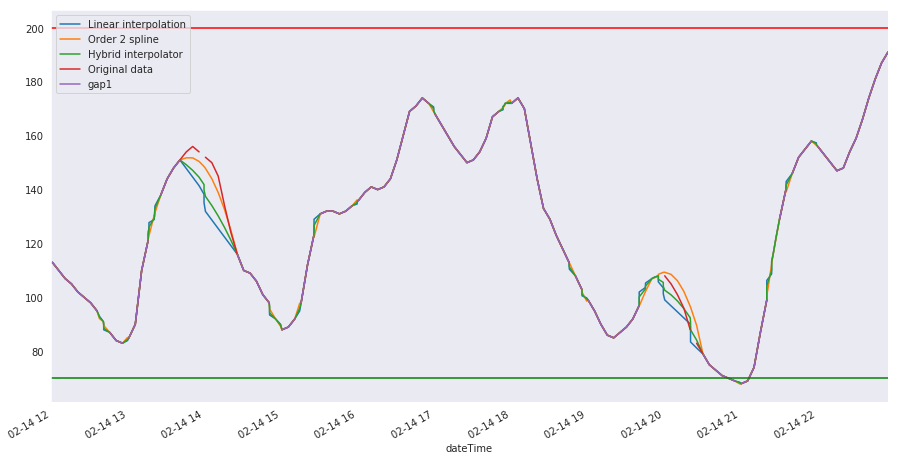

In [374]:
gap1.interpolate(method='linear').plot()
gap1.interpolate(method='spline', order=2).plot()
hybrid_interpolator(gap1).plot()
test_day.plot()
gap1.plot()
plt.axhline(200, color='red')
plt.axhline(70, color='green')
plt.legend(['Linear interpolation', 'Order 2 spline', 'Hybrid interpolator', 'Original data', 'gap1'])

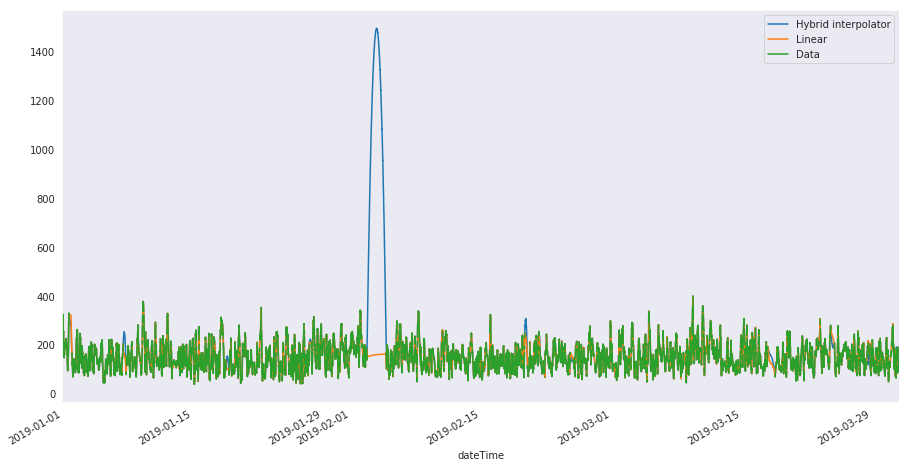

In [351]:
hybrid_interpolator(proc1.loc['2019/01':'2019/03']['Sensor Glucose (mg/dL)']).plot()
proc1.loc['2019/01':'2019/03']['Sensor Glucose (mg/dL)'].interpolate(method='linear', limit_direction='both').plot()
#proc1.loc['2019/01':'2019/03']['Sensor Glucose (mg/dL)'].rolling(2).mean().plot()
proc1.loc['2019/01':'2019/03']['Sensor Glucose (mg/dL)'].plot()
plt.legend(['Hybrid interpolator', 'Linear', 'Data'])

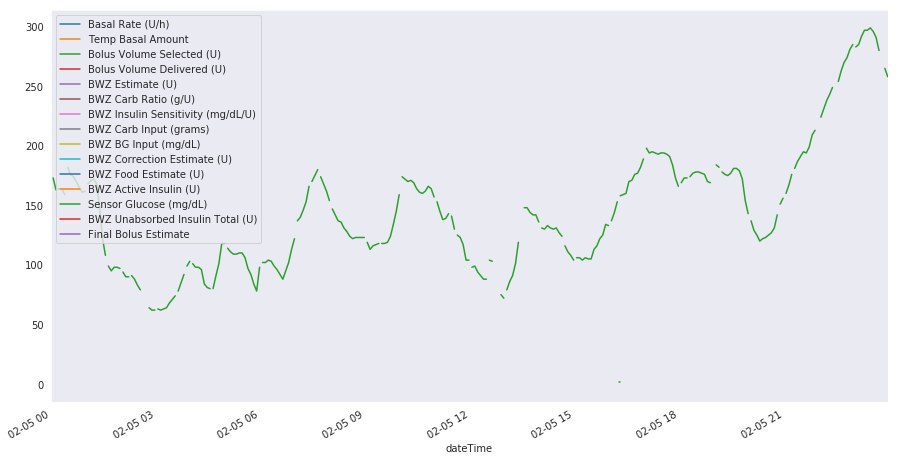

In [384]:
proc1.loc['2019/02/05'].plot()

In [107]:
proc1.iloc[0, :], proc1.iloc[len(proc1.index)-1, :]

(New Device Time                                   NaN
 BG Reading (mg/dL)                                NaN
 Linked BG Meter ID                                NaN
 Basal Rate (U/h)                                  NaN
 Temp Basal Amount                                 NaN
 Temp Basal Type                                   NaN
 Temp Basal Duration (h:mm:ss)                     NaN
 Bolus Type                                        NaN
 Bolus Volume Selected (U)                         NaN
 Bolus Volume Delivered (U)                        NaN
 Bolus Duration (h:mm:ss)                          NaN
 Prime Type                                        NaN
 Prime Volume Delivered (U)                        NaN
 Alarm                                             NaN
 Suspend                                           NaN
 Rewind                                            NaN
 BWZ Estimate (U)                                  NaN
 BWZ Target High BG (mg/dL)                        NaN
 BWZ Targe

In [29]:
with open('dateTime.txt', 'w') as f:
    for i in raw['dateTime']:
        f.write(f'{i}\n')

In [30]:
raw.index, raw['Index']

(RangeIndex(start=0, stop=96130, step=1), 0            0.0
 1            1.0
 2            2.0
 3            3.0
 4            4.0
 5            5.0
 6            6.0
 7            7.0
 8            8.0
 9            9.0
 10          10.0
 11          11.0
 12          12.0
 13          13.0
 14          14.0
 15          15.0
 16          16.0
 17          17.0
 18          18.0
 19          19.0
 20          20.0
 21          21.0
 22          22.0
 23          23.0
 24          24.0
 25          25.0
 26          26.0
 27          27.0
 28          28.0
 29          29.0
           ...   
 96100    96100.0
 96101    96101.0
 96102    96102.0
 96103    96103.0
 96104    96104.0
 96105    96105.0
 96106    96106.0
 96107    96107.0
 96108    96108.0
 96109    96109.0
 96110    96110.0
 96111    96111.0
 96112    96112.0
 96113    96113.0
 96114    96114.0
 96115    96115.0
 96116    96116.0
 96117    96117.0
 96118    96118.0
 96119    96119.0
 96120    96120.0
 96121    96121.0
 9612

In [31]:
raw['New Device Time'].count()

9

In [32]:
raw[ raw['New Device Time'].notnull() ]['New Device Time']

273      2019/04/20 19:45:26
274      2019/04/20 19:45:26
837      2019/04/16 09:15:48
838      2019/04/16 09:15:48
2633     2019/04/01 12:06:12
2634     2019/04/01 12:06:12
3684     2019/03/23 11:03:58
3685     2019/03/23 11:03:58
12864    2019/01/05 12:42:13
Name: New Device Time, dtype: object

In [33]:
list(
    map(
        type, list(raw[ raw['Sensor Glucose (mg/dL)'].notnull() ]['Sensor Glucose (mg/dL)'])
    )
)

[float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,


In [34]:
glucosas = raw[ raw['Sensor Glucose (mg/dL)'].notnull() ]['Sensor Glucose (mg/dL)']

In [35]:
glucosas = pd.to_numeric(glucosas, 'coerce')

In [36]:
glucosas = glucosas[glucosas == glucosas // 1]

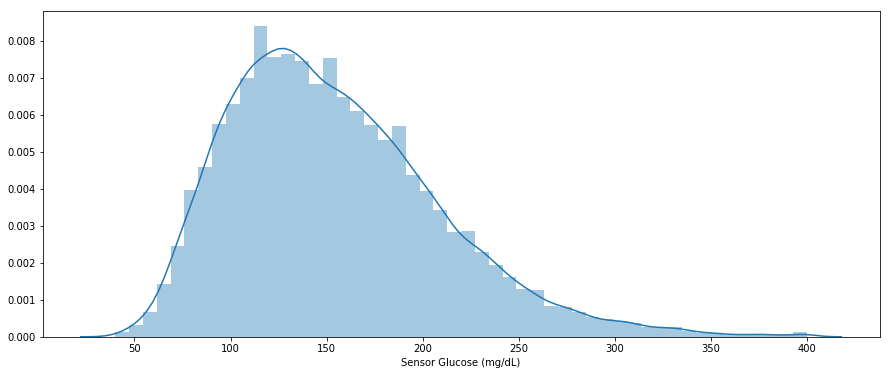

In [37]:
sb.distplot(glucosas)

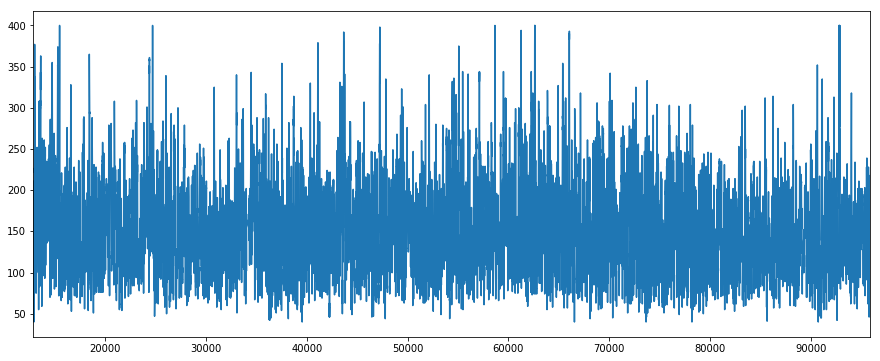

In [38]:
glucosas.plot()

In [46]:
proporciones = (lambda borne_inf, borne_sup: 
                { 
                    'hypo':  100 * glucosas[glucosas < borne_inf].count() / glucosas.count(),
                    'normo': 100 * glucosas[(glucosas >= borne_inf) & (glucosas <=borne_sup)].count() / glucosas.count(),
                    'hyper': 100 * glucosas[glucosas > borne_sup].count() / glucosas.count()
                }
)(70, 160)

In [48]:
proporciones

{'hypo': 2.0057487204054363,
 'normo': 57.465772421270266,
 'hyper': 40.5284788583243}

In [49]:
glucosas.mean(), glucosas.std()

(154.36552280577897, 55.004304897107545)

In [50]:
raw['BWZ Estimate (U)'].count()/90

7.611111111111111

In [184]:
#raw.iloc[0,:], raw.iloc[len(raw.index)-1, :]
data = np.random.multivariate_normal([0, 0], [[5, 2], [2, 2]], size=2000)
data = pd.DataFrame(data, columns=['x', 'y'])
data

,x,y
0,2.141126,0.940255
1,3.921847,-0.863210
2,0.490261,0.539941
3,3.543376,1.407672
4,-1.487025,-0.251110
5,2.255612,0.634059
6,-1.858856,-0.129140
7,-1.286445,-0.786163
8,-0.683575,0.731284
9,-0.923125,0.210444


In [29]:
x = pd.core.frame.DataFrame()

In [96]:
'''
glucosas = filter(lambda x: x if not np.isnan(x) else False,
                  list(
                    map(int, glucosas)
                    )
            )
#Value error: cannot convert float NaN to integer
'''    

'\nglucosas = filter(lambda x: x if not np.isnan(x) else False,\n                  list(\n                    map(int, glucosas)\n                    )\n            )\n#Value error: cannot convert float NaN to integer\n'

In [118]:
np.array([[1], [2], [3]])

array([[1],
       [2],
       [3]])

In [247]:
(raw['Sensor Glucose (mg/dL)'].dropna())[ raw['Sensor Glucose (mg/dL)'] > 120 ][['Sensor Glucose (mg/dL)', 'Time', 'Date']]

KeyError: "None of [Index(['Sensor Glucose (mg/dL)', 'Time', 'Date'], dtype='object')] are in the [index]"

In [254]:
proc1[ proc1['Sensor Glucose (mg/dL)'] == 140 ]

,Basal Rate (U/h),Temp Basal Amount,Bolus Volume Selected (U),Bolus Volume Delivered (U),BWZ Estimate (U),BWZ Carb Ratio (g/U),BWZ Insulin Sensitivity (mg/dL/U),BWZ Carb Input (grams),BWZ BG Input (mg/dL),BWZ Correction Estimate (U),BWZ Food Estimate (U),BWZ Active Insulin (U),Sensor Glucose (mg/dL),BWZ Unabsorbed Insulin Total (U),Final Bolus Estimate
dateTime,,,,,,,,,,,,,,,
2018-06-23 21:12:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
2018-06-24 04:22:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
2018-06-24 10:57:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
2018-06-25 07:22:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
2018-06-26 09:57:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
2018-06-26 17:27:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
2018-06-26 17:32:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
2018-06-26 17:37:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
2018-06-26 17:42:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
